# Модель прогноза прироста наличности в банковских терминалах

Спонсор задачи  №6 хакатона "Лидеры цифровой трансформации"  ОАО "ГАЗПРОМБАНК" определил ряд бизнес целей для оптимизации процессов обслуживания банковских терминалов. В рамках решения общей задачи командой Team.Light выделена подзадача прогнозирования нличности в банковских терминалах. Здесь представлено решение и его обоснование.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
import os
from datetime import datetime
import pickle
import os

In [86]:
# from google.colab import drive

In [87]:
#!pip install pmdarima
import pmdarima as pm

In [88]:
#mount_name = '/virt_drive'
#disk_name = './' #mount_name + '/MyDrive/Colab Notebooks'
project_name = './' #'/ds_hack2023'
path_2_data = 'data/cash_in_terminals.csv'


In [89]:
#drive.mount(mount_name)

In [90]:
data = pd.read_csv(project_name + path_2_data, sep=';')
data.head()

,TID,остаток на 31.08.2022 (входящий),2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000
2,406145,287000,143000,136000,124000,117000,123000,140000,139000,138000,...,119000,100000,179000,169000,118000,118000,114000,128000,121000,124000
3,406148,355000,50000,73000,53000,65000,75000,100000,53000,52000,...,48000,55000,65000,85000,95000,68000,62000,0,118000,70000
4,406180,597000,96000,82000,71000,72000,86000,55000,55000,75000,...,82000,56000,70000,59000,105000,70000,77000,87000,59000,55000


In [91]:
col_cash_in = 'sum_start'
data.rename(columns={'остаток на 31.08.2022 (входящий)': col_cash_in}, inplace=True)
tid_df = data[['TID', col_cash_in]].copy()
#tid_lst = list(tid_df['TID'])
tid_df.set_index('TID', inplace=True)
data.drop(columns=[col_cash_in], inplace=True)
data.head()

,TID,2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,2022-09-09 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,90000,105000,99000,107000,110000,60000,75000,89000,95000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,103000,206000,168000,124000,78000,165000,164000,174000,88000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000
2,406145,143000,136000,124000,117000,123000,140000,139000,138000,118000,...,119000,100000,179000,169000,118000,118000,114000,128000,121000,124000
3,406148,50000,73000,53000,65000,75000,100000,53000,52000,82000,...,48000,55000,65000,85000,95000,68000,62000,0,118000,70000
4,406180,96000,82000,71000,72000,86000,55000,55000,75000,75000,...,82000,56000,70000,59000,105000,70000,77000,87000,59000,55000


In [92]:
data = data.transpose()
data.columns = data.loc['TID'].values
data.drop(index='TID', axis=0, inplace=True)
data.index = pd.to_datetime(data.index)
data.head()

,406136,406139,406145,406148,406180,406190,406196,406504,406509,406536,...,699451,699540,699560,699572,699577,699578,699579,699629,699641,699664
2022-09-01,90000,103000,143000,50000,96000,219000,115000,382000,128000,63000,...,47000,80000,110000,124000,0,0,49000,63000,63000,0
2022-09-02,105000,206000,136000,73000,82000,236000,123000,317000,126000,65000,...,61000,102000,57000,0,25000,0,68000,63000,0,0
2022-09-03,99000,168000,124000,53000,71000,218000,121000,479000,170000,0,...,68000,140000,155000,152000,0,10000,0,63000,0,47000
2022-09-04,107000,124000,117000,65000,72000,212000,120000,333000,113000,0,...,76000,78000,192000,161000,0,0,0,64000,51000,0
2022-09-05,110000,78000,123000,75000,86000,207000,96000,232000,120000,201000,...,51000,196000,127000,53000,27000,10000,13000,74000,0,43000


In [93]:
data.index.is_monotonic_increasing, data.index.has_duplicates

(True, False)

In [94]:
len(tid_df), len(data)

(1630, 91)

In [95]:
np.min(data.values), np.max(data.values), np.sum((data == 0).values), np.sum(data.isna().values)

(0, 2697000, 8334, 0)

In [96]:
# смотрим кол-во столбцов (tid), где вообще не было 0
np.sum(np.sum((data == 0).values, axis=0) == 0)

616

#### Выводы после ознакомления с данными
- Всего предоставлено монотонных ежедневных данные за три месяца (91 день) о 1630 терминалах. 
- Отрицательных приростов нет
- Пропусков нет
- 0-вые приросты встречаются достаточно часто - 8334 раза, только примерно в трети точках не было нулевых приростов. Как было подчеркнуто на встрече, 0-вые приросты это только 0-приросты, а не сведения о состоявшемся обслуживании (этот тезис подтверждается наличием 616 точек без 0 в течение всего периода отложенной выборки). 
- Максимальный  прирост в 2,7 миллиона рублей
- Есть только данные и приросте, по дням за три месяца. Никаких экзогенных предсказующих признаков (кроме тех, что можно извлечь из дат - праздники, выходные и пр.) у нас в распоряжении нет. Поэтому основной кандидат для модели предсказания наличности - SARIMAX


In [97]:
PLOT_W = 16
PLOT_H = 2
PVAL_MAX = .05 # for stationarity definition and for selections AR lags
LAGS_MAX = 14 # for ACF/PACF analysis
#PVAL_MIN = .1 
D_TEST = 30
path_2_results = '/results'
path_2_models_results = path_2_results + '/models_results'

## Анализ данных

In [98]:
def check_stationarity(series): # Проверяем стационарность Эд-Фуллером
    result = adfuller(series.values)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'      {key: >3}: {value:.3f}')
    print()
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("Time series is stationary")
    else:
        print("Time series is non-stationary")
    return result

def show_acf_pacf(data, max_lags=LAGS_MAX, ax=None): # Смотрим ACF/PACF
    if ax is None:
        f, ax = plt.subplots(nrows=2, ncols=1, figsize=(PLOT_W, 2*PLOT_H + 1))
    plot_acf(data, lags=list(range(1, max_lags+1)), ax=ax[0])
    plot_pacf(data, lags=list(range(1, max_lags+1)), ax=ax[1], method='ywm') # 'ywm' make PACF in [-1,1]
    #plt.tight_layout()
    plt.show()
    
def plot_ts(col_lst, df=data, max_curves=3): # Рисуем любое кол-во ts (rare)
    rows = (len(col_lst) - 1) // max_curves + 1
    if rows > 1:
        fig, axs = plt.subplots(nrows=rows, ncols=1, figsize=(PLOT_W, rows * (PLOT_H + 1.5)))
        for i in range(rows):
            df[col_lst[i * max_curves : (i + 1) * max_curves]].plot(ax=axs[i], grid=True)
            axs[i].tick_params(axis='x', labelsize=0)
            axs[i].axvline(df.index[-D_TEST], color='red', linestyle=':')
    else:
        df[col_lst].plot(figsize=(PLOT_W, PLOT_H), grid=True)
        #ax.axvline(df.index[-D_TEST], color='red', linestyle=':')

# Показываем конкретный ds: собственно ts, все его производные до стационарности, PACF/ACF стационарного ряда
def show_ts(tid, df=data, tid_df=tid_df, max_lags=14):
    #col_ranks = [f'is_stationary_d{i}' for i in range(max_rank + 1)]
    curr_rank = tid_df.loc[tid, 'rank']
    fig, axs = plt.subplots(nrows=curr_rank + 3, ncols=1, figsize=(PLOT_W, (curr_rank + 3) * (PLOT_H + 1)))
    curve_to_diff = df[tid].copy()
    curve_to_diff.plot(ax=axs[0], grid=True)
    axs[0].set_title(f'Прирост наличности в терминале {tid}', fontsize=10) 
    axs[0].tick_params(axis='x', labelsize=0)
    for i in range(1, curr_rank + 1):
        curve_to_diff = curve_to_diff.diff().dropna()
        curve_to_diff.plot(ax=axs[i], grid=True)
        axs[i].set_title(f'{i}-производная прироста наличности в терминале {tid}', fontsize=10)
        axs[i].tick_params(axis='x', labelsize=0)
    show_acf_pacf(df[tid].values, max_lags=max_lags, ax=axs[-2:])
    return

def csv_dump(df, fn='some_df', suff='_last'):
    path = disk_name + project_name + path_2_models_results
    fn = f'{path}/{fn}{suff}.csv'
    df.to_csv(fn)
    #print(fn)
    return pd.DataFrame()

### Проверка стационарности

Основной вопрос для применимости моделей SARIMAX - стационарность ряда (в простейшем случае I=0) или стационарность производных ряда (I > 0). Поэтому ниже оценим стационарность временных рядов каждого терминала

In [99]:
stationary = [] # разделим все терминалы по степени интегрированности
is_non_stationary = True
rank = 0
tid_to_process = tid_df.index.to_list()

while tid_to_process:
    for col in tid_to_process: # ADF-test для ...
        ts = data[col].copy() # данных или ...
        for _ in range(rank): # для соотв. разностей
            ts = ts.diff().dropna()
        result = adfuller(ts.values)
        tid_df.loc[col, f'd{rank}_pval_ADFtest'] = result[1]

    tid_df.loc[tid_df[f'd{rank}_pval_ADFtest'] < PVAL_MAX, 'rank'] = rank

    stationary.append(list(tid_df[ (tid_df['rank'] == rank )].index))
    tid_to_process = list(tid_df[tid_df['rank'].isna()].index)
    rank += 1

tid_df['rank'] = tid_df['rank'].astype('int')

In [100]:
[ (i, len(lst)) for i, lst in enumerate(stationary)]

[(0, 1311), (1, 315), (2, 4)]

####  Выводы по стационарности.
- 1311 терминалов имеют стационарные ряды приростов наличности 
- 315 терминалов имеют стационарность относительно 1й производной
- 4 терминала стационарны относительно 2й производной

Таким образом, подтверждается наша идея использовать SARIMA в качестве базового предиктора

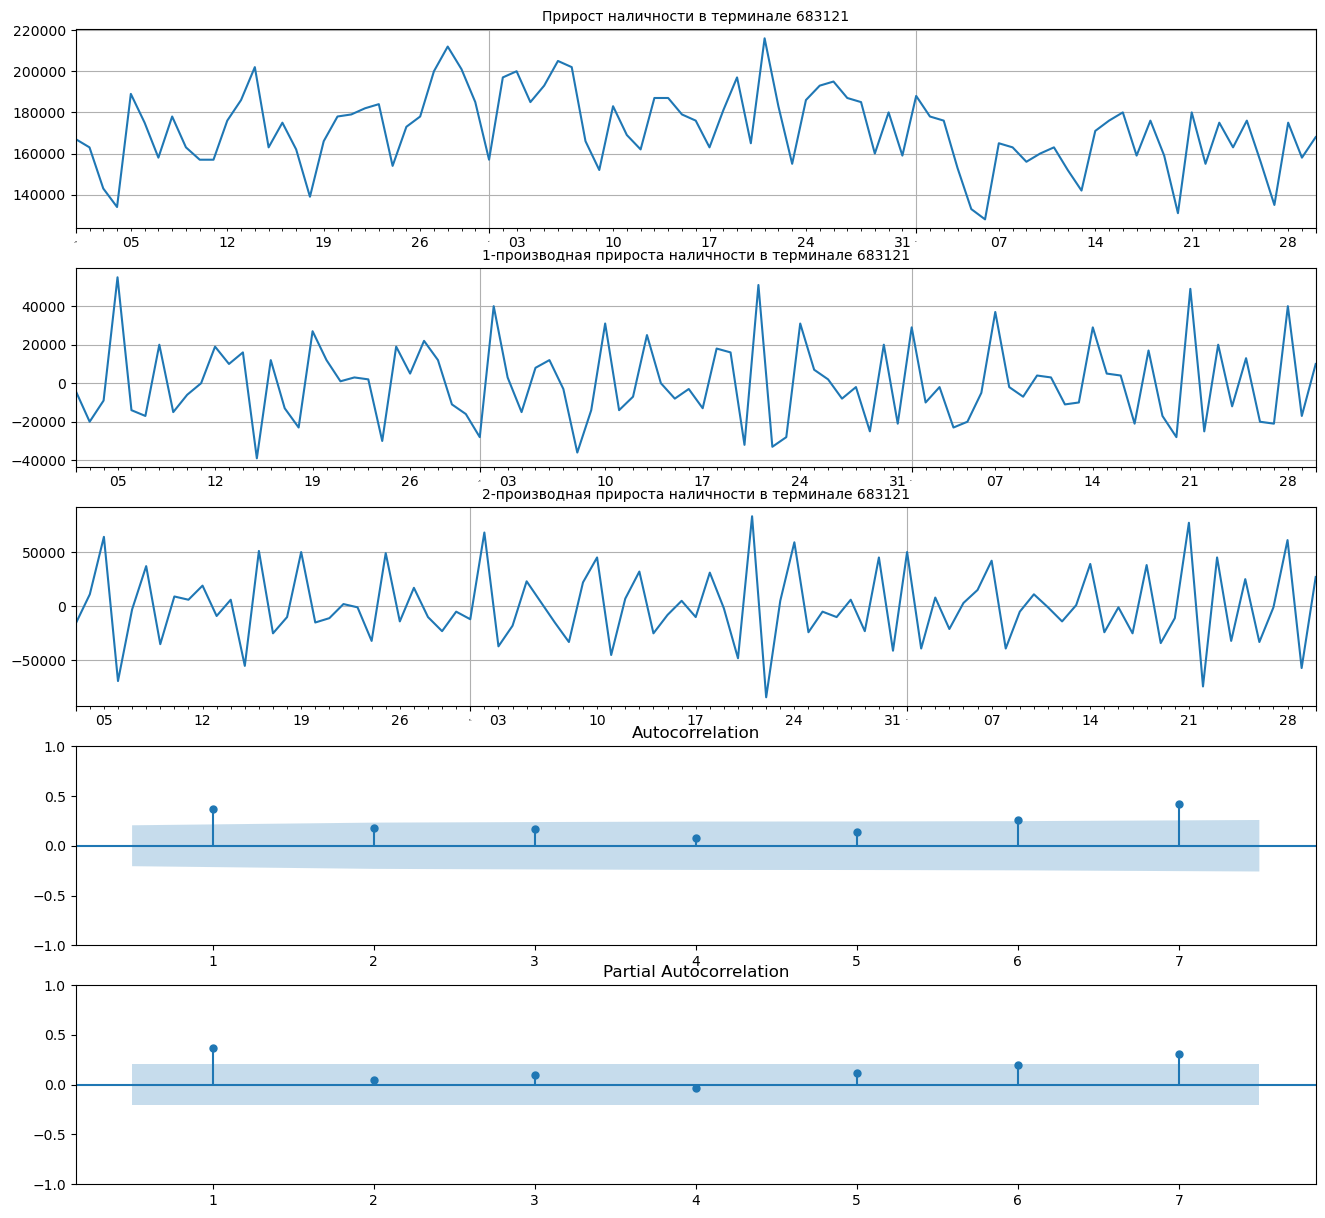

In [101]:
# посмотрим на какой-нибудь из рядов, имеющий самый высокий порядок диффернцирования, до стационарности
tid = stationary[2][2]
show_ts(tid, max_lags=7)

### Исследование выбросов.

In [102]:
# нас интересуют выбросы по статистическим параметрам train выборки, запомним необходимые статистики
for tid in tid_df.index:
    ts_to_statistic = data[:-D_TEST][tid].copy()
    mean_ts = ts_to_statistic.mean()
    tid_df.loc[tid, 'mean_train'] = mean_ts
    tid_df.loc[tid, 'sigma_train'] = ts_to_statistic.var() ** .5
    tid_df.loc[tid, 'median_train'] = ts_to_statistic.quantile()
    tid_df.loc[tid, '0.75q_train'] = ts_to_statistic.quantile(.75)
    tid_df.loc[tid, '0.90q_train'] = ts_to_statistic.quantile(.9)
    tid_df.loc[tid, 'max_outlier'] = data[tid].max() - mean_ts

#### Выбросы по статистическим критериям.

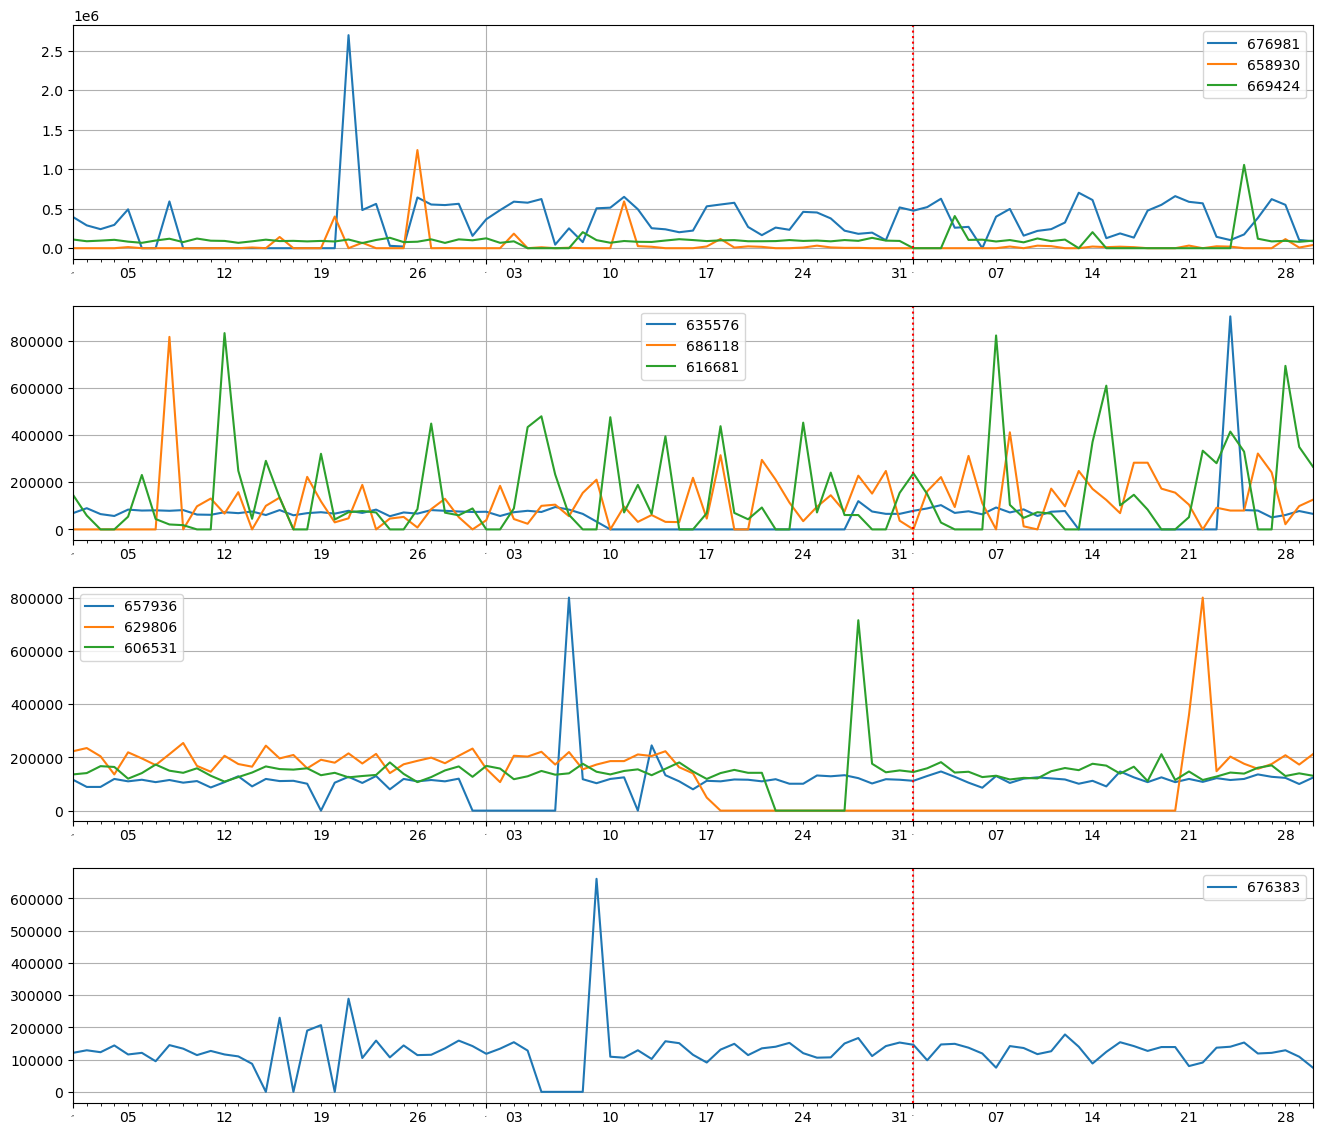

In [103]:
# посмотрим на приросты в терминалах с самыми большими выбросами по абсолютному значению
tid_max_outlier = tid_df.sort_values(by='max_outlier', ascending=False).head(10).index
plot_ts(tid_max_outlier)

In [104]:
# ниже посмотрим на выбросы выше чем 3 сигма
tid_out_3sigma = tid_df[tid_df.max_outlier > tid_df.mean_train + 3 * tid_df.sigma_train].sort_values(by='max_outlier', ascending=False).index

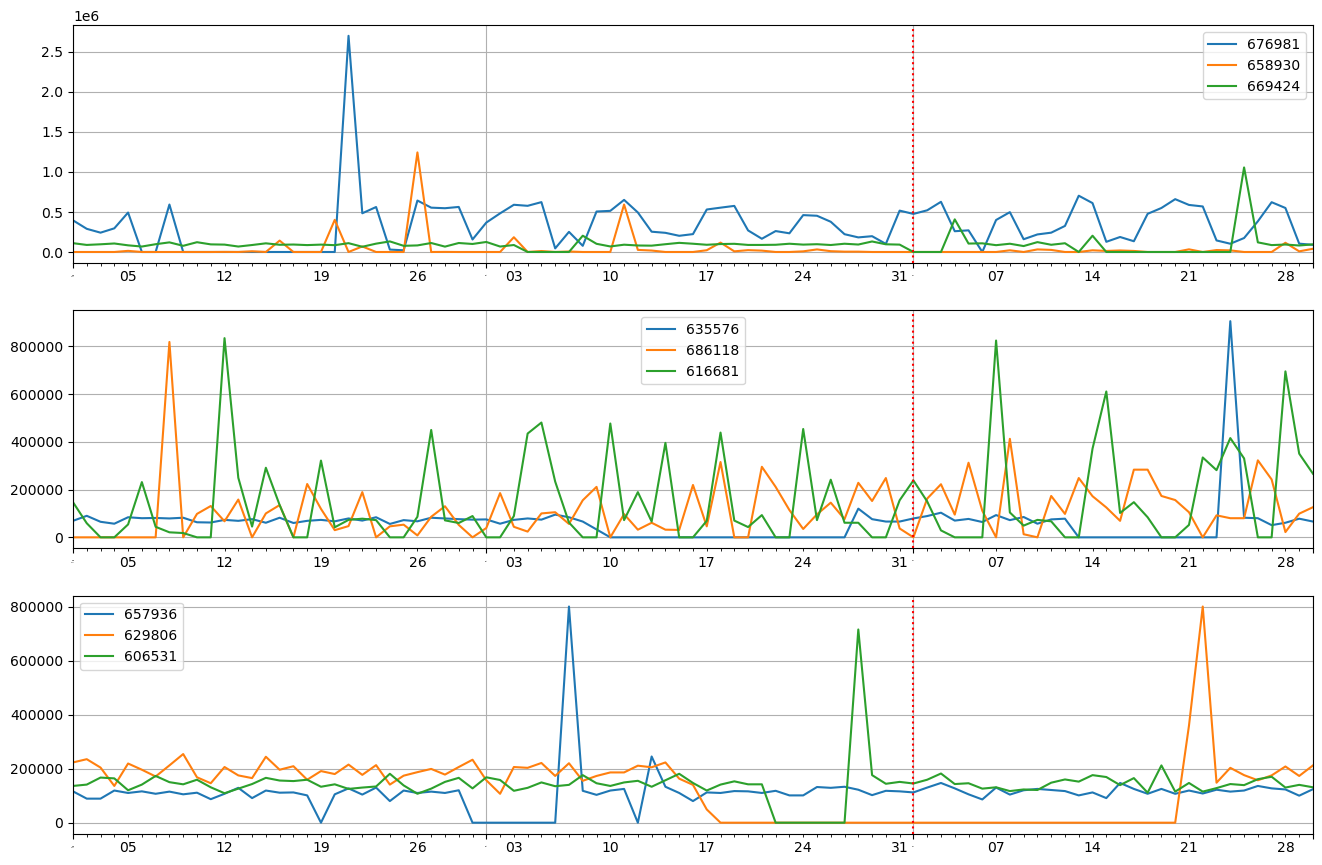

In [105]:
# выведем графики 9 терминалов с самыми большими выбросами
plot_ts(tid_out_3sigma[:9])

#### Выводы исследования выбросов
- Есть достаточное кол-во выбросов, которые буду приводить к переполнению терминалов.
- Среди таких выбросов точно есть такие, которые SARIMAX модель не предскажет, например, терминалы 635576 и 629806. В этих терминалах выбросы в тестовом периоде точно не будут предсказаны SARIMAX моделью.
-  Может быть есть какие то признаки, которые можно добавить в модель в качестве экзогенных факторов? Или построить дополнительный предиктор выбросов?

#### Гипотеза 1: 
- После внимательного изучения графиков c выбросами во временных рядах возникла гипотеза - может быть ненормальные пики связаны с 0-выми приростами в предыдущие дни? 
- Проверим! 

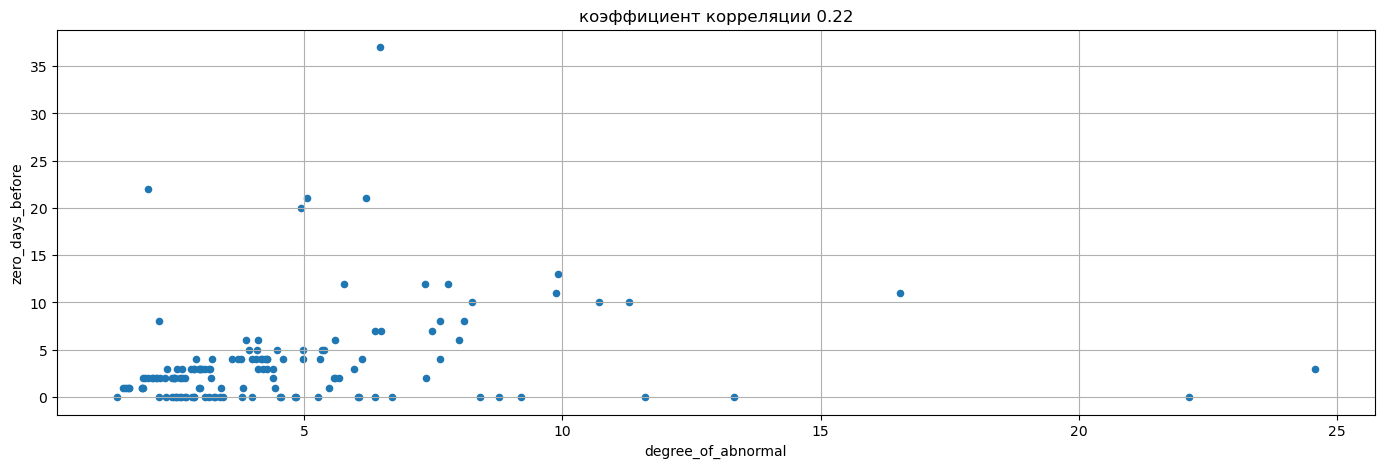

In [106]:
# посмотрим на корреляцию между выбросами и количеством дней до выброса с нулевым приростом
count_abnormal = pd.DataFrame()
for tid in tid_out_3sigma:
    count_abnormal.loc[tid, 'degree_of_abnormal'] = tid_df.loc[tid, 'max_outlier'] / tid_df.loc[tid, 'mean_train'] 
    index_max = data[tid].idxmax()
    loc = data.index.get_loc(index_max)
    day_shift = 1
    while data.iloc[loc - day_shift, :][tid] < 100:
        day_shift += 1
    count_abnormal.loc[tid, 'zero_days_before'] = day_shift - 1
ax = count_abnormal.plot(x='degree_of_abnormal', y='zero_days_before', kind='scatter', figsize=(17,5), grid=True, title=f'коэффициент корреляции {count_abnormal.corr().iloc[0,1]:.2f}')

###### Коэффициент линейной корреляции 0.22
- Связь действительно есть и достаточно сильная
- Смущает правый нижний угол графика - есть знчительная доля больших выбросов, в которых кол-во нулевых дней непосредственно перед выбросом равно нулю 

In [107]:
# посмотрим на те терминалы, в которых есть выбросы, но нулей непосредственно перед выбросами нет
super_abnormal_df = count_abnormal[count_abnormal.zero_days_before == 0].sort_values(by='degree_of_abnormal', ascending=False)
super_abnormal_df.head()

,degree_of_abnormal,zero_days_before
606043,22.145143,0.0
699578,13.324853,0.0
699577,11.591743,0.0
680614,9.200000,0.0
680612,8.760000,0.0


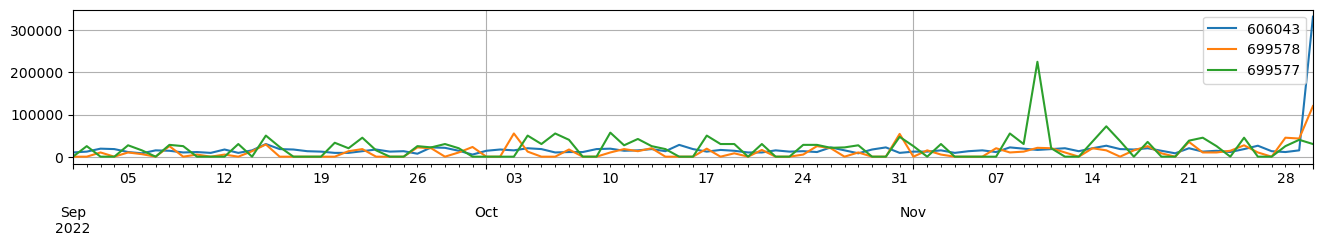

In [108]:
plot_ts(super_abnormal_df[:3].index)

In [109]:
tid_super_abnormal = [606043]
print(data[data[tid_super_abnormal[0]] < 100].index)
tid_df.loc[tid_super_abnormal[0]]

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


sum_start           48000.000000
d0_pval_ADFtest         0.715760
rank                    1.000000
d1_pval_ADFtest         0.026014
d2_pval_ADFtest              NaN
mean_train          14344.262295
sigma_train          4830.062960
median_train        14000.000000
0.75q_train         17000.000000
0.90q_train         20000.000000
max_outlier        317655.737705
Name: 606043, dtype: float64

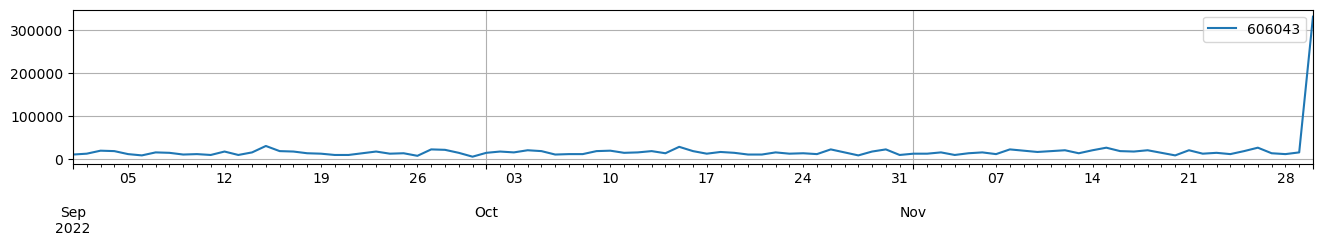

In [110]:
plot_ts(tid_super_abnormal[0:1])

#### Выводы по гипотезе 1:
- Коэффициент корреляции между кол-вом нулевых приростов перед выбросом и величиной выброса 0.22 и этот признак обладает хорошей предсказательной силой.
- Однако одного такого признака явно недостаточно - на диаграмме рассеяния видно, что есть большое кол-во значительных выбросов, непосредственно перед которыми не было дней с нулевыми приростами
- Может быть не следует считать нули непосредственно перед выбросом, а ввести более сложный индикатор? Например, посчитаем долю нулевых приростов в некотором окне, скажем 5, 20 или даже 30?
- Проверим!

#### Гипотеза 2:
- Выброс может длиться несколько дней. Перед большим выбросом, может быть некоторый прирост.  
- Посмотрим, как связана вероятность выброса не с кол-вом нулевых дней, обязательно предшествующих выборсу, а с долей нулевых дней в заранее заданном окне перед выбросом.

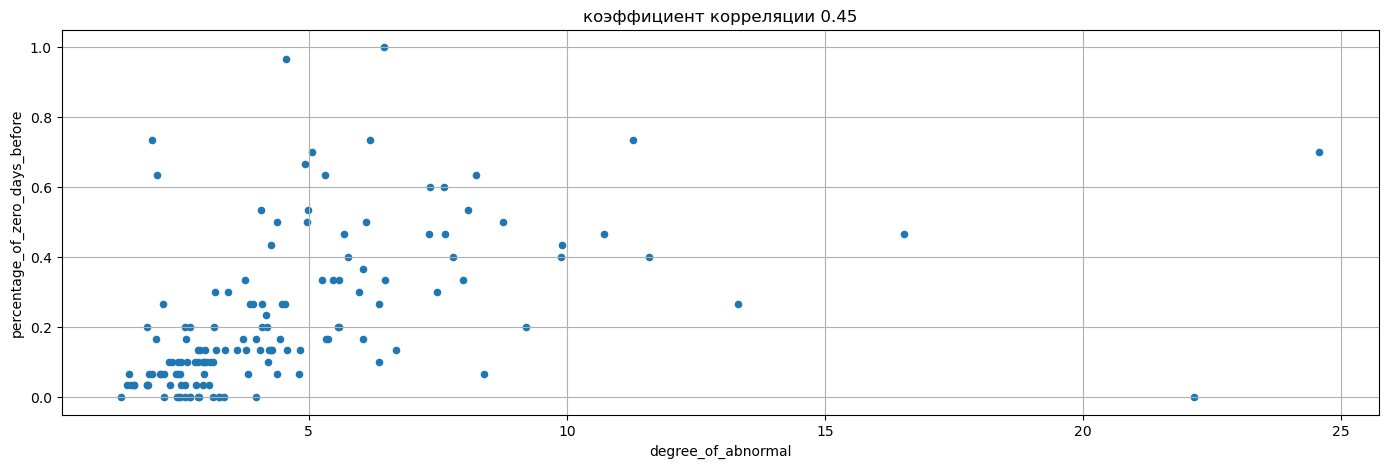

In [111]:
# смотрим корреляцию между долей нулевых дней и степенью выброса
count_abnormal_2 = pd.DataFrame()
zero_window = 30
for tid in tid_out_3sigma:
    count_abnormal_2.loc[tid, 'degree_of_abnormal'] = tid_df.loc[tid, 'max_outlier'] / tid_df.loc[tid, 'mean_train'] 
    index_max = data[tid].idxmax()
    loc = data.index.get_loc(index_max)
    count_zero = 0
    for day_shift in range(1, zero_window + 1):
        if data.iloc[loc - day_shift, :][tid] < 100:
            count_zero += 1
    count_abnormal_2.loc[tid, 'percentage_of_zero_days_before'] = count_zero / zero_window
ax = count_abnormal_2.plot(x='degree_of_abnormal', y='percentage_of_zero_days_before', kind='scatter', figsize=(17,5), grid=True, title=f'коэффициент корреляции {count_abnormal_2.corr().iloc[0,1]:.2f}')

###### Коэффициент линейной корреляции 0.45!
- Связь сильная
- По прежнему правый нижний угол графика - есть знчительная доля больших выбросов, в которых кол-во нулевых дней непосредственно перед выбросом равно нулю 

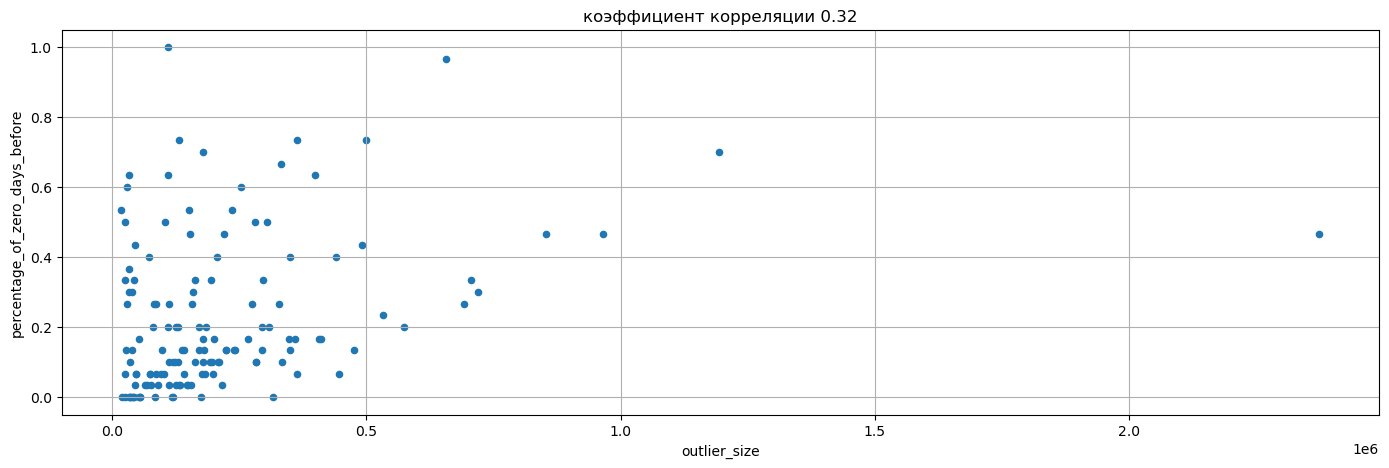

In [112]:
# смотрим корреляцию между долей нулевых дней и абсолютным размером выброса
count_abnormal_2 = pd.DataFrame()
zero_window = 30
for tid in tid_out_3sigma:
    count_abnormal_2.loc[tid, 'outlier_size'] = tid_df.loc[tid, 'max_outlier'] 
    index_max = data[tid].idxmax()
    loc = data.index.get_loc(index_max)
    count_zero = 0
    for day_shift in range(1, zero_window + 1):
        if data.iloc[loc - day_shift, :][tid] < 100:
            count_zero += 1
    count_abnormal_2.loc[tid, 'percentage_of_zero_days_before'] = count_zero / zero_window
ax = count_abnormal_2.plot(x='outlier_size', y='percentage_of_zero_days_before', kind='scatter', figsize=(17,5), grid=True, title=f'коэффициент корреляции {count_abnormal_2.corr().iloc[0,1]:.2f}')

#### Выводы по гипотезе 2:
- Очевидно, что доля нулевых приростов в некотором заданном окне до выброса является гораздо более сильным предиктором, чем просто кол-во нулевых дней непосредственно перед выбросом. Коэффициенты корреляции варьировались от 0.3 до 0.45.
- Последний график (правый нижний угол, вернее, отсутствие точек в нем) говорит о том, что при выборе небольшой доли (0.1-0.2) нулевых приростов в некотором окне, мы можем построить простой предиктор, который будет прогнозировать все большие приросты. Однако платой за такой низкий уровень сигнала, очевидно, будт то, что такой предиктор будет генерировать очень много ложных сигналов (false positive), а это может привести к перегрузке нашего парка броневиков. 
- Оценим!

#### Оценка качества логистического предиктора

In [113]:
def build_data_for_logistic(ts_tid, window_size=15, **cond_dict):
    df = pd.DataFrame(ts_tid)
    df.columns = ['cash']
    for shift_number in range(1, window_size + 1):
        df[f'shift_{shift_number}'] = df['cash'].shift(shift_number)
    df = df.dropna()
    #col_lst = df.columns.tolist()
    #col_lst = [col for col in col_lst if 'shift_' in col]
    shifts_only          = df.drop(columns=['cash'])
    shifts_only_binary   = shifts_only.where(shifts_only==0, 1)
    total_days_in_window = len(shifts_only.columns)
    new_col_val = pd.Series(index=df.index, dtype='float')
    new_col_val = (total_days_in_window - shifts_only_binary.sum(axis=1)) / total_days_in_window
    df['zeros_ratio'] =  new_col_val #(total_days_in_window - shifts_only_binary.sum(axis=1)) / total_days_in_window   #.apply(count_zero_in_lags, axis=1)
    
    #filter_for_1 = df['cash'] > cond_dict['median_train'] + cond_dict['sigma_train']
    #df['y'] = np.where(filter_for_1, 1, 0)
    return df['zeros_ratio']

In [114]:
data_zr = data.copy()

In [115]:
# считаю долю 0 до текущей даты для разных окон (2, 5 и 15 дней перед выбросом)
# df получается фрагментированной, однако нам нужно проверить разные окна и разные thresholds
w_sizes = [2, 5, 15]
cols_new = [f'{tid}_zr_ws{w_size}' for tid in tid_df.index for w_size in w_sizes]
df_for_new_cols = pd.DataFrame(index=data.index, columns=cols_new)

for tid in tid_df.index:
    ts_to_process = data_zr[tid]
    all_windows_before = pd.DataFrame(index=data_zr.index)
    train_mean = tid_df.loc[tid, 'mean_train']
    sigma_train = tid_df.loc[tid, 'sigma_train']
    median_train = tid_df.loc[tid, 'median_train']
    
    for w_size in w_sizes: 
        df_for_new_cols[f'{tid}_zr_ws{w_size}'] = build_data_for_logistic(ts_to_process, window_size=w_size, mean_train=train_mean, sigma_train=sigma_train, median_train=median_train)
        #col_name = f'{tid}_zr_ws{w_size}'
        #data_zr[col_name] = data_for_lg['zeros_ratio']

data_zr = pd.concat([data_zr, df_for_new_cols], axis=1)

In [116]:
tid_to_validate = str(699577)
cols_to_validate = [col for col in data_zr.columns if tid_to_validate in str(col)]
data_zr[cols_to_validate][55:65]

,699577,699577_zr_ws2,699577_zr_ws5,699577_zr_ws15
2022-10-26,21000,0.0,0.4,0.333333
2022-10-27,22000,0.0,0.4,0.333333
2022-10-28,27000,0.0,0.2,0.333333
2022-10-29,0,0.0,0.0,0.333333
2022-10-30,0,0.5,0.2,0.400000
2022-10-31,47000,1.0,0.4,0.400000
2022-11-01,25000,0.5,0.4,0.333333
2022-11-02,0,0.0,0.4,0.333333
2022-11-03,30000,0.5,0.6,0.400000
2022-11-04,0,0.5,0.4,0.400000


In [117]:
cols_zr_6520 = data_zr.columns

In [118]:
#thresh_for_signal = 0.2 # True для 1 из 2, 2 из 5, 4 из 15
#thresh_for_signal = 0.39 # True для 1 из 2, 3 из 5, 6 из 15
#thresh_for_signal = 0.49 # True для 1 из 2, 3 из 5, 8 из 15
thresh_for_signal = 0.79 # True для 2 из 2, 4 из 5, 12 из 15
def signals_a_day_to_set(row_has_filtered):
    signals = {int(col.split('_')[0]) for col in row_has_filtered[row_has_filtered > thresh_for_signal].index}
    return signals#, len(signals)

In [119]:
for ws in [2, 5, 15]:
    filter_with = f'ws{ws}'
    cols_filtered = [col for col in cols_zr_6520 if filter_with in str(col)]
    
    col_4_set = f'signals_from_{filter_with}_thresh_{thresh_for_signal*100:.0f}%'
    col_4_len = f'total_sgnls_from_{filter_with}_thresh_{thresh_for_signal*100:.0f}%'
    #print(len(cols_filtered), col_4_set, col_4_len)
    data_zr[col_4_set] = data_zr[cols_filtered].apply(signals_a_day_to_set, axis=1)
    data_zr[col_4_len] = data_zr[col_4_set].apply(lambda x: len(x))

In [120]:
# 1 из 2, 2 из 2, 2 из 5, 3 из 5, 4 из 5, 4 из 15, 6 из 15, 8 из 15, 12 из 15
cols_with_total = [col for col in data_zr.columns if 'total_' in str(col)]
#cols_2_descr = [col for col in cols_with_total if 'thresh_79' in col or 'thresh_49' in col]
#cols_2_descr += [col for col in data_zr.columns if 'thresh_49' in str(col)]
#cols_2_descr += [col for col in cols_with_total if 'ws15_thresh_39' in col or 'ws15_thresh_20' in col]
#cols_2_descr += ['signal_from_ws15_thresh_39%', 'signal_from_ws15_thresh_20%']
data_zr[cols_with_total].describe().transpose().sort_values(by='max')#loc[['max', 'mean']]

,count,mean,std,min,25%,50%,75%,max
total_sgnls_from_ws15_thresh_79%,91.0,4.439560,4.077605,0.0,2.0,3.0,6.0,16.0
total_sgnls_from_ws5_thresh_79%,91.0,15.197802,7.365414,0.0,10.5,14.0,18.5,31.0
total_sgnls_from_ws2_thresh_79%,91.0,27.296703,11.736453,0.0,20.0,25.0,34.0,68.0


###### Предварительные выводы по качеству простого предиктора:
- Таблица выше показывает какое кол-во сигналов ежедневно будут генерировать простые предикторы. И это кол-во достаточно велико! Приемлемое кол-во сигналов ежедневно должно быть не более 15-30 штук. И главный вопрос - а будет ли такое кол-во сигналов предсказывать большие выбросы?
- Проверим

In [121]:
# это для повторных прогонов
data_zr = data_zr.drop(columns=[col for col in data_zr.columns if 'outlie' in str(col)])

In [122]:
# создадим для каждого tid boolean столбец now_outliered
thres_for_abs_val = 500_000
thres_for_sigma_mult = 1

for tid in tid_df.index:
    filter_col = (data_zr[tid] > thres_for_abs_val) & (data_zr[tid] > thres_for_sigma_mult * tid_df.loc[tid, 'sigma_train'])
    data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_zr[f'{tid}_is_outlier'] = np.where(filter_col, True, False)
/var/folders/t2/65vk95dd04nfxrlsx0g786h00000gn/T/ipykernel_73184/996065894.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [123]:
# создадим из tids с целевым признаком True  мн-ва для каждой даты
def targets_a_day_to_set(row_has_filtered):
    row_has_filtered[row_has_filtered].index
    tids_outliered = {int(col.split('_')[0]) for col in row_has_filtered[row_has_filtered].index}
    return tids_outliered

col_lst_to_process = [col for col in data_zr.columns if 'is_outlier' in str(col)]
data_zr['outliered_tids'] = data_zr[col_lst_to_process].apply(targets_a_day_to_set, axis=1)

In [124]:
# сохраним длину полученных мн-в
data_zr['total_outlrd_tids'] = data_zr['outliered_tids'].apply(lambda x: len(x))
data_zr['total_outlrd_tids'].describe()

count    91.000000
mean      1.725275
std       0.870069
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       4.000000
Name: total_outlrd_tids, dtype: float64

In [125]:
# проверим совпадают ли сигналы с целью :)
sets_with_signals = [col for col in data_zr.columns if 'signals_from' in str(col)]
for col in sets_with_signals:
    suff = '_'.join(col.split('_')[2:5])
    data_zr[f'outliers_after_{suff}'] = data_zr['outliered_tids'] - data_zr[col]

In [126]:
for col in [col for col in data_zr.columns if 'outliers_after_' in str(col)]:
    data_zr[f'total_{col}'] = data_zr[col].apply(lambda x: len(x))
#data_zr[cols].apply(lambda x: len(x)).describe()

In [127]:
data_zr[[col for col in data_zr.columns if 'total_outliers_after_' in str(col)]].describe().transpose().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
total_outliers_after_ws2_thresh_79%,91.0,1.505495,0.735959,0.0,1.0,1.0,2.0,3.0
total_outliers_after_ws5_thresh_79%,91.0,1.560440,0.763163,0.0,1.0,2.0,2.0,3.0
total_outliers_after_ws15_thresh_79%,91.0,1.670330,0.843998,0.0,1.0,2.0,2.0,4.0


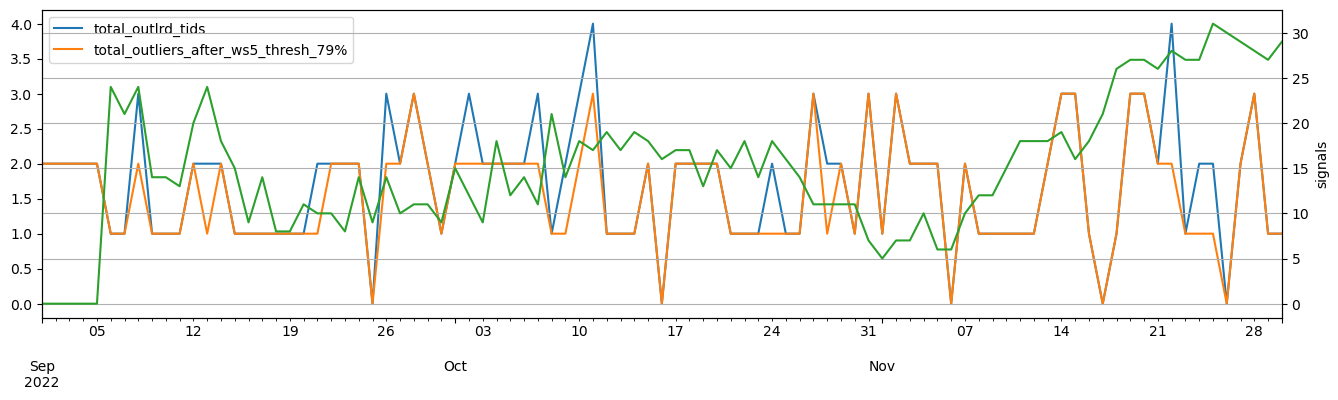

In [128]:
ax = data_zr[['total_outlrd_tids', 'total_outliers_after_ws5_thresh_79%']].plot(figsize=(PLOT_W, PLOT_H + 2))
ax = data_zr['total_sgnls_from_ws5_thresh_79%'].plot(secondary_y=True, grid=True, ax=ax)
_ = ax.set_ylabel('signals')


#### Выводы по качеству простого предиктора:
- К сожалению, простой предиктор плохо справляется с поставленной задачей
- Даже при значительном кол-ве ежедневных сигналов (зеленый график), такой предиктор не предсказывает значительное кол-во выбросов (оранжевый график - это непредсказанные выбросы на каждый день)

#### Гипотеза 3:
- Проверим сколько разных терминалов генерировали выбросы и если этот список невелик, просто повысим приоритетность заезда в эти терминалы на стадии формирования маршрутов. 
- Конечно, это не решит полностью проблемы - даже на стадии первичного анализа выбросов мы обнаружили терминалы, в которых на протяжении всего срока train не было никаких выбросов, а во время тестового периода такие выбросы произошли.



In [129]:
# будем смотреть выбросы только в train выборке
train_data = data[:-D_TEST].copy()
outliers = train_data.where(train_data > 500_000, 0).where(train_data <= 500_000, 1)

In [130]:
train_data[-3:].index

DatetimeIndex(['2022-10-29', '2022-10-30', '2022-10-31'], dtype='datetime64[ns]', freq=None)

In [131]:
tids_total_outliers = outliers.sum(axis=0)

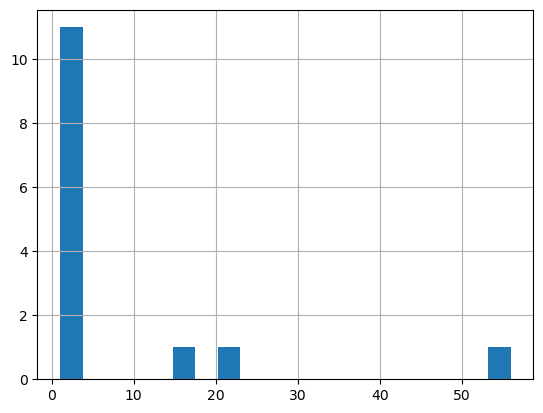

In [132]:
ax = tids_total_outliers[tids_total_outliers > 0].hist(bins=20)

In [133]:
outliers_lst = tids_total_outliers[tids_total_outliers > 0].sort_values(ascending=False).index.tolist() 

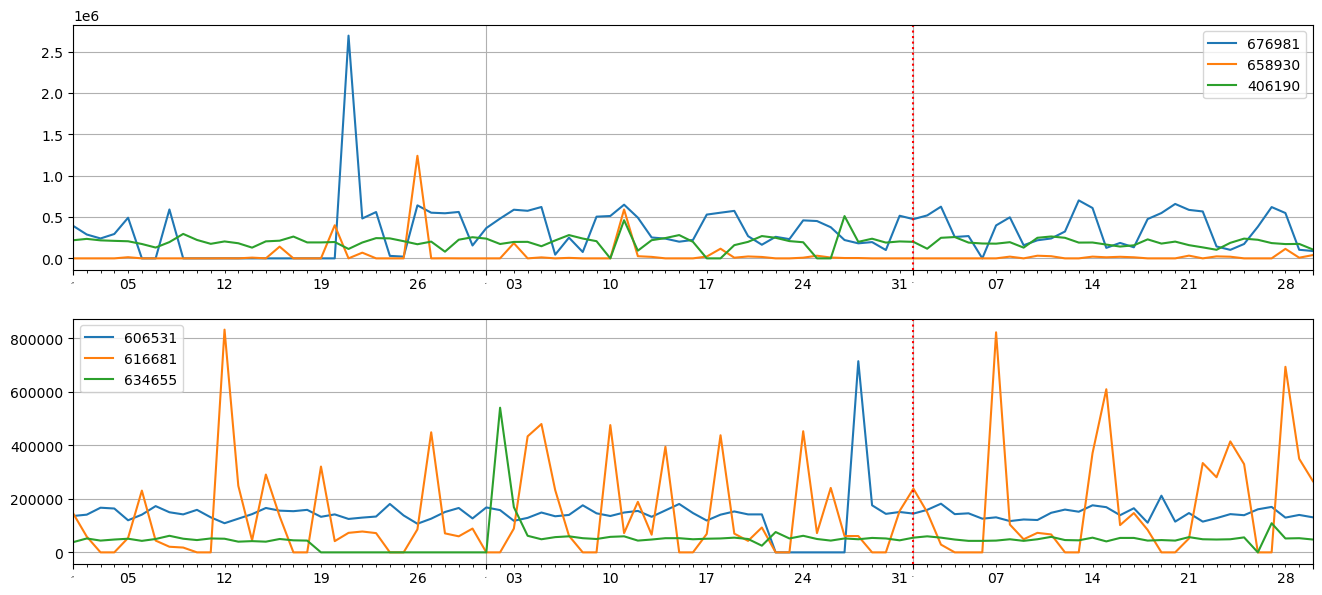

In [134]:
plot_ts(outliers_lst[2:8])

#### Выводы по гипотезе 3:
Выделяем список из 16 терминалов, в которых исходя из статистического анализ train  данных вероятность значительных выбросов высока, и повышаем на весь срок тестового периода приоритет их обслуживания.

### Выводы исследования выбросов.
- Были выдвинуты несколько гипотез для построения дополнительных признаков для прогноза выбросов. 
- Такие признаки можно было бы использовать либо как основные признаки  бинарного классификатора (такой классификатор использовался бы в дополнение к основной модели SARIMA), либо как экзогенные признаки в модели SARIMA.
- Оценка возможных показателей качества классификатора (ежедневное количество ложных сигналов о выбросах и доля успешных предсказаний) привела нас к заключению, что бинарный классификатор не увеличит эффективность общей модели проекта. 
- **Заключение:** Основная модель прогноза приростов наличности - SARIMA. Плюс необольшой список терминалов (<20) с повышенным приоритетом обслуживания.

## Моделирование.

In [135]:
def show_predictions(compare_df, ds_name='', max_lags=LAGS_MAX, title='test'):
    y_true = compare_df['fact']
    y_hat = compare_df['predict']  
    show_acf = (title != 'test')
    nrows = 2 + show_acf * 2
    fig, axs = plt.subplots(nrows=nrows, ncols=1, figsize=(PLOT_W, nrows * (PLOT_H + 1.5)))
    compare_df.plot(ax=axs[0])
    axs[0].set_title(f'RMSE on {ds_name} {title} set: {mean_squared_error(y_true, y_hat) ** 0.5: .2f}')
    resid = y_true - y_hat
    resid.plot(ax=axs[1])
    result = sm.stats.diagnostic.acorr_ljungbox(resid - np.mean(resid), lags=max_lags, return_df=True)
    axs[1].set_title(f'График остатков, Среднее: {np.mean(resid): .2f} Тест Льюинга-Бокса после обнуления среднего до {max_lags}го лага мин={min(result.lb_pvalue): .6f}, макс={max(result.lb_pvalue): .6f}')
    if show_acf:
        show_acf_pacf(resid, ax=axs[2:], max_lags=max_lags)

def show_predictions_full(compare_df_full, ds_name='', days_for_test=D_TEST, show_train=False):
    show_predictions(compare_df_full[-days_for_test:], ds_name=ds_name)
    if show_train:
        show_predictions(compare_df_full[:-days_for_test], ds_name=ds_name, title='train')

def fit_sarima(ts, order=(0,0,0), seasonal_order=(0, 0, 0, 0)):
    model = ARIMA(ts, order=order, seasonal_order=seasonal_order, freq='1D')
    return model.fit()

def show_predictions_sarima(ts, days_for_test=D_TEST, order=(0,0,0), seasonal_order=(0, 0, 0, 0), show_train=False):
    train = ts[:-days_for_test].copy()
    test =  ts[-days_for_test:].copy()
    model_fitted = fit_sarima(train, order=order, seasonal_order=seasonal_order)
    compare_df = pd.DataFrame(ts)
    compare_df.columns = ['fact']
    
    compare_df['predict'] = model_fitted.predict(start=ts.index[0], end=ts.index[-1])
    
    show_predictions_full(compare_df, ds_name=train.name, days_for_test=days_for_test, show_train=show_train)
    return model_fitted

def show_predictions_autoarima_fitted(model_fitted, ts_full, days_for_test=D_TEST, show_train=False):
    compare_df = pd.DataFrame(ts_full)
    compare_df.columns = ['fact']

    prediction = model_fitted.predict(n_periods=days_for_test)
    predict_in_sample = model_fitted.predict_in_sample()
    compare_df.loc[prediction.index, 'predict'] = prediction
    compare_df.loc[predict_in_sample.index, 'predict'] = predict_in_sample

    show_predictions_full(compare_df, ds_name=ts_full.name, days_for_test=days_for_test, show_train=show_train)

def show_predictions_autoarima(ts, days_for_test=D_TEST, season_order=7, show_train=False):
    model_fitted = pm.auto_arima(ts[:-days_for_test].copy(), seasonal=True, m=season_order)
    show_predictions_autoarima_fitted(model_fitted, ts, days_for_test=D_TEST, show_train=show_train)
    return model_fitted

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


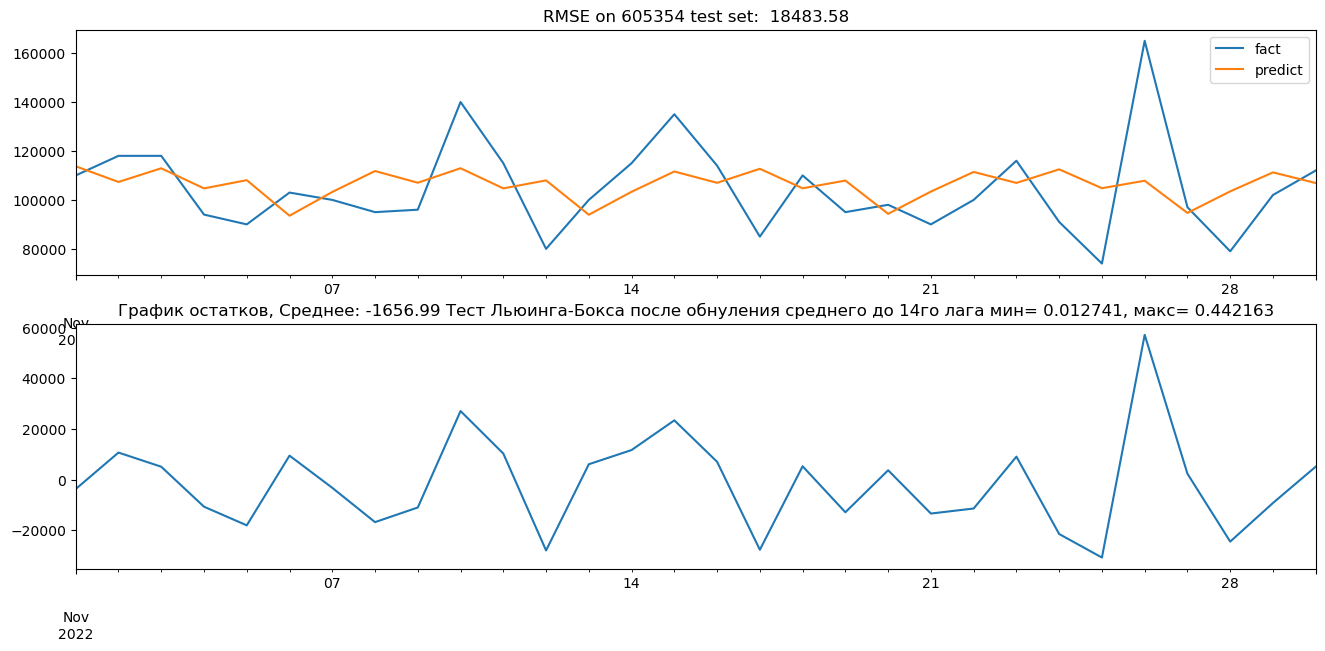

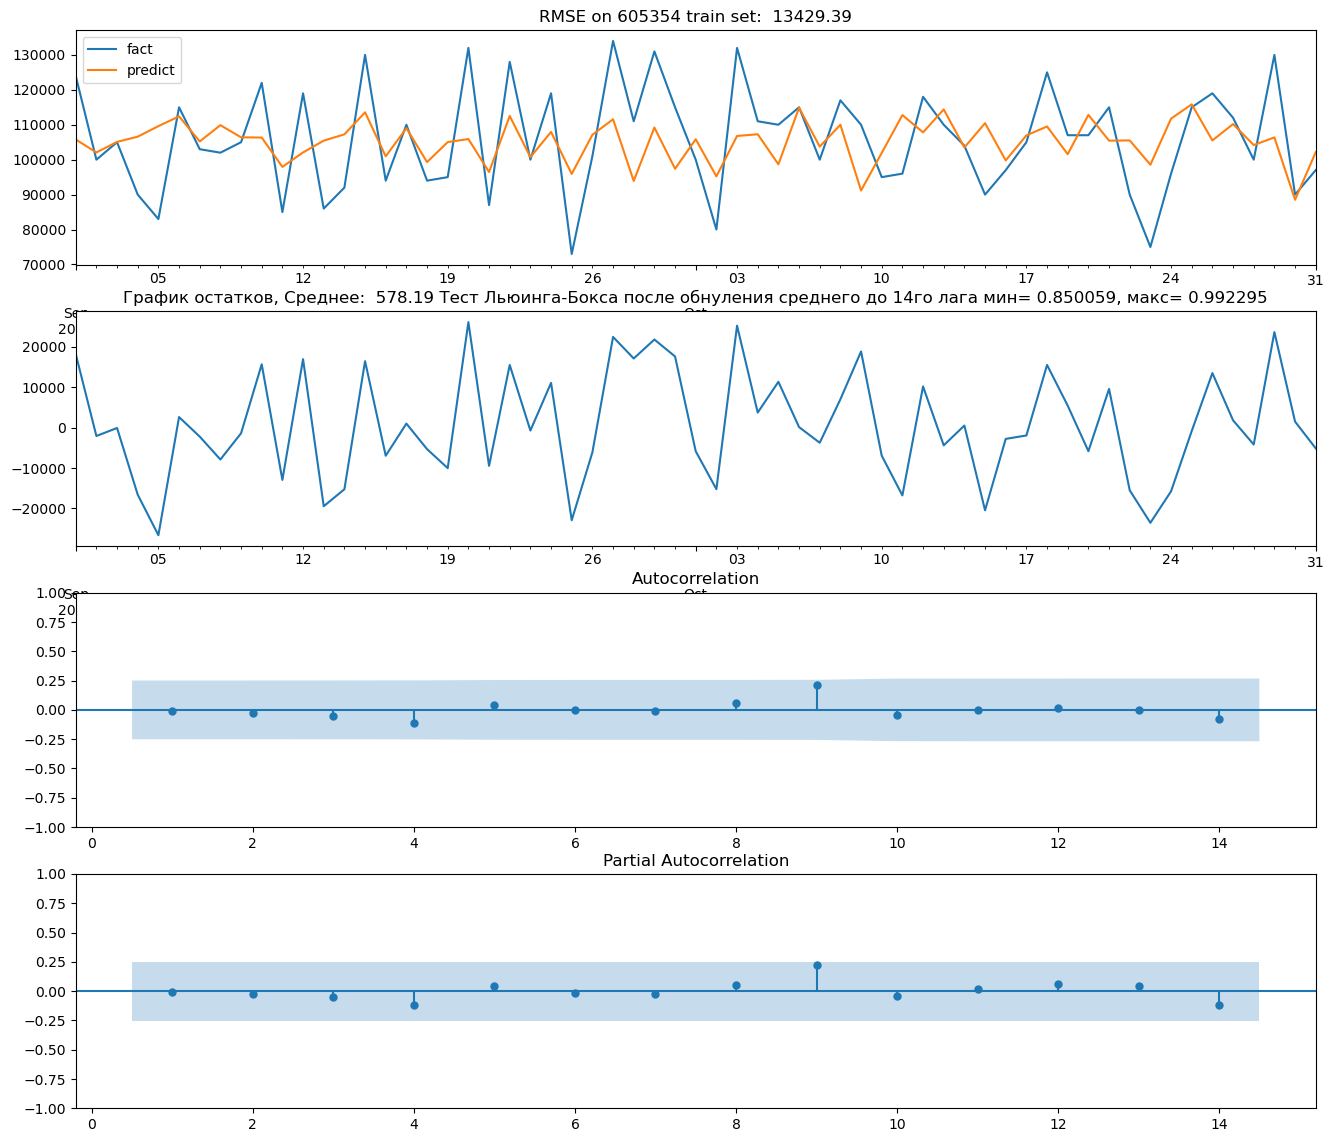

In [136]:
models_h = {}
tid_modeling = 605354
models_h[tid_modeling] = {}
models_h[tid_modeling]['arima_h'] = show_predictions_sarima(data[tid_modeling], order=(2, 0, 0), seasonal_order=(1, 0, 1, 7), show_train=True)

In [137]:
models_h[tid_modeling]['arima_h'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            605354   No. Observations:                   61
Model:             ARIMA(2, 0, 0)x(1, 0, [1], 7)   Log Likelihood                -667.077
Date:                           Sun, 28 May 2023   AIC                           1346.154
Time:                                   21:53:03   BIC                           1358.819
Sample:                               09-01-2022   HQIC                          1351.118
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.058e+05   3167.987     33.392      0.000    9.96e+04    1.12e+05
ar.L1         -0.2264      0.175     -1.291      0.197      -0.570       0.117
ar.L2         -0.1091      0.169     -0.644      0.520      -0.441       0.223
ar.S.L7        0.9681      0.137      7.046      0.000       0.699       1.237
ma.S.L7       -0.8555      0.341     -2.512      0.012      -1.523      -0.188
sigma2      2.142e+08      0.016   1.34e+10      0.000    2.14e+08    2.14e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.98   Prob(JB):                         0.39
Heteroskedasticity (H):               0.82   Skew:                             0.09
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+26. Standard errors may be unstable.
"""

#### Auto SARIMA

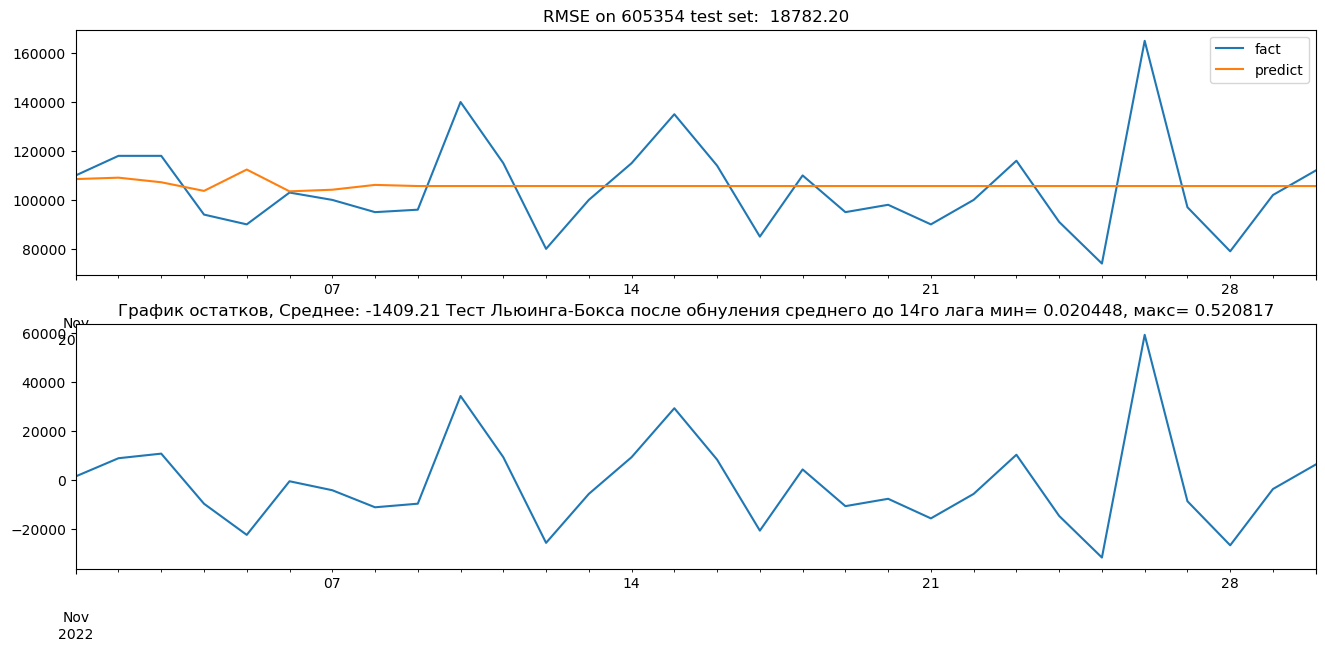

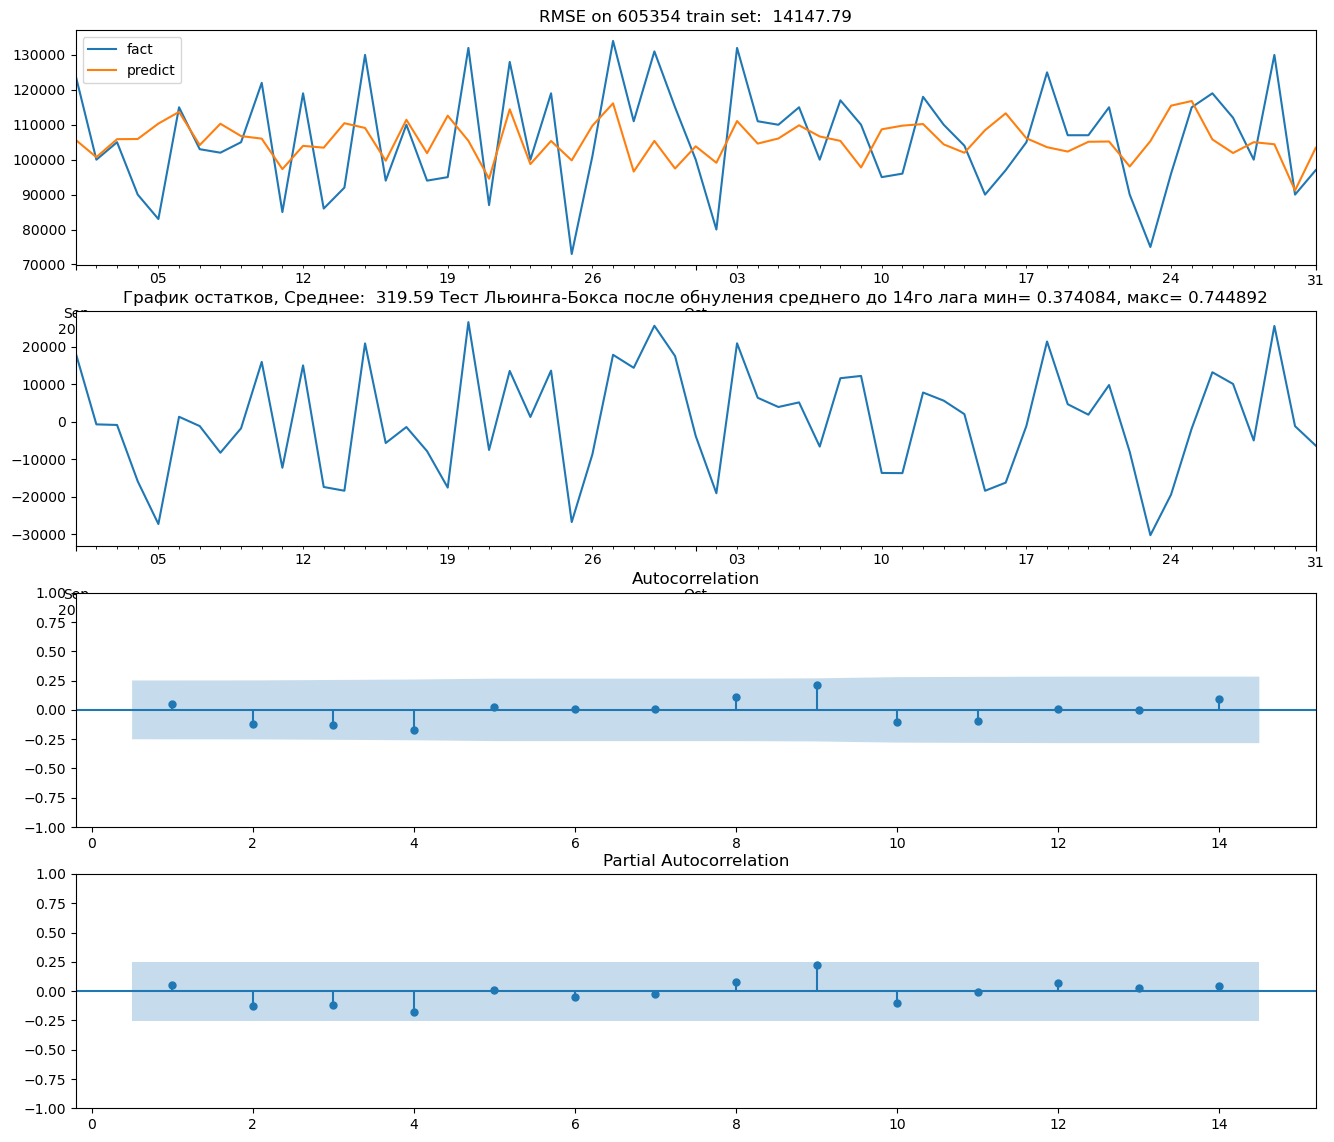

In [138]:
#model_auto_fitted = pm.auto_arima(data[605354].copy()[:-30], seasonal=True, m=7)
#tid_modeling = 605354
# models[tid_modeling] = {}
models_h[tid_modeling]['arima_auto'] = show_predictions_autoarima(data[tid_modeling].copy(), season_order=7, show_train=True)

In [139]:
models_h[tid_modeling]['arima_auto'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 7)   Log Likelihood                -669.764
Date:                           Sun, 28 May 2023   AIC                           1347.529
Time:                                   21:53:45   BIC                           1355.972
Sample:                               09-01-2022   HQIC                          1350.838
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.057e+05   1850.051     57.114      0.000    1.02e+05    1.09e+05
ma.L1         -0.2934      0.144     -2.044      0.041      -0.575      -0.012
ma.S.L7        0.2491      0.156      1.602      0.109      -0.056       0.554
sigma2      2.241e+08      0.002    1.3e+11      0.000    2.24e+08    2.24e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.68   Prob(JB):                         0.47
Heteroskedasticity (H):               0.88   Skew:                            -0.07
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+28. Standard errors may be unstable.
"""

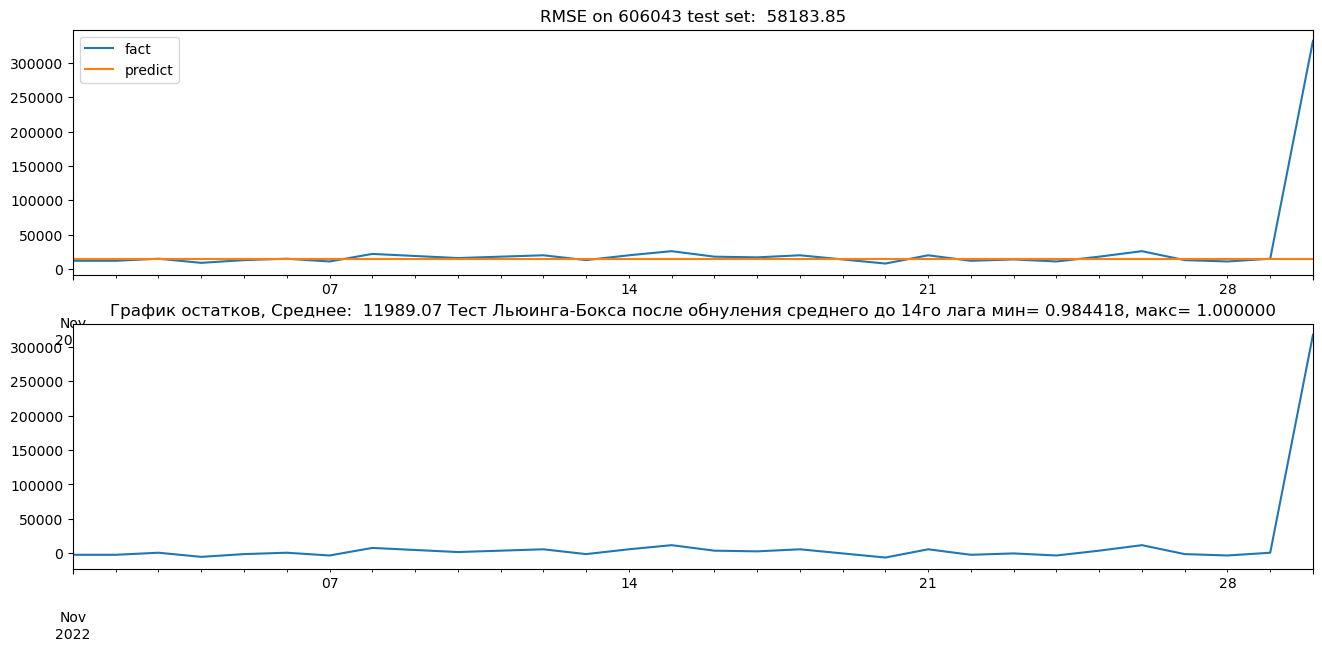

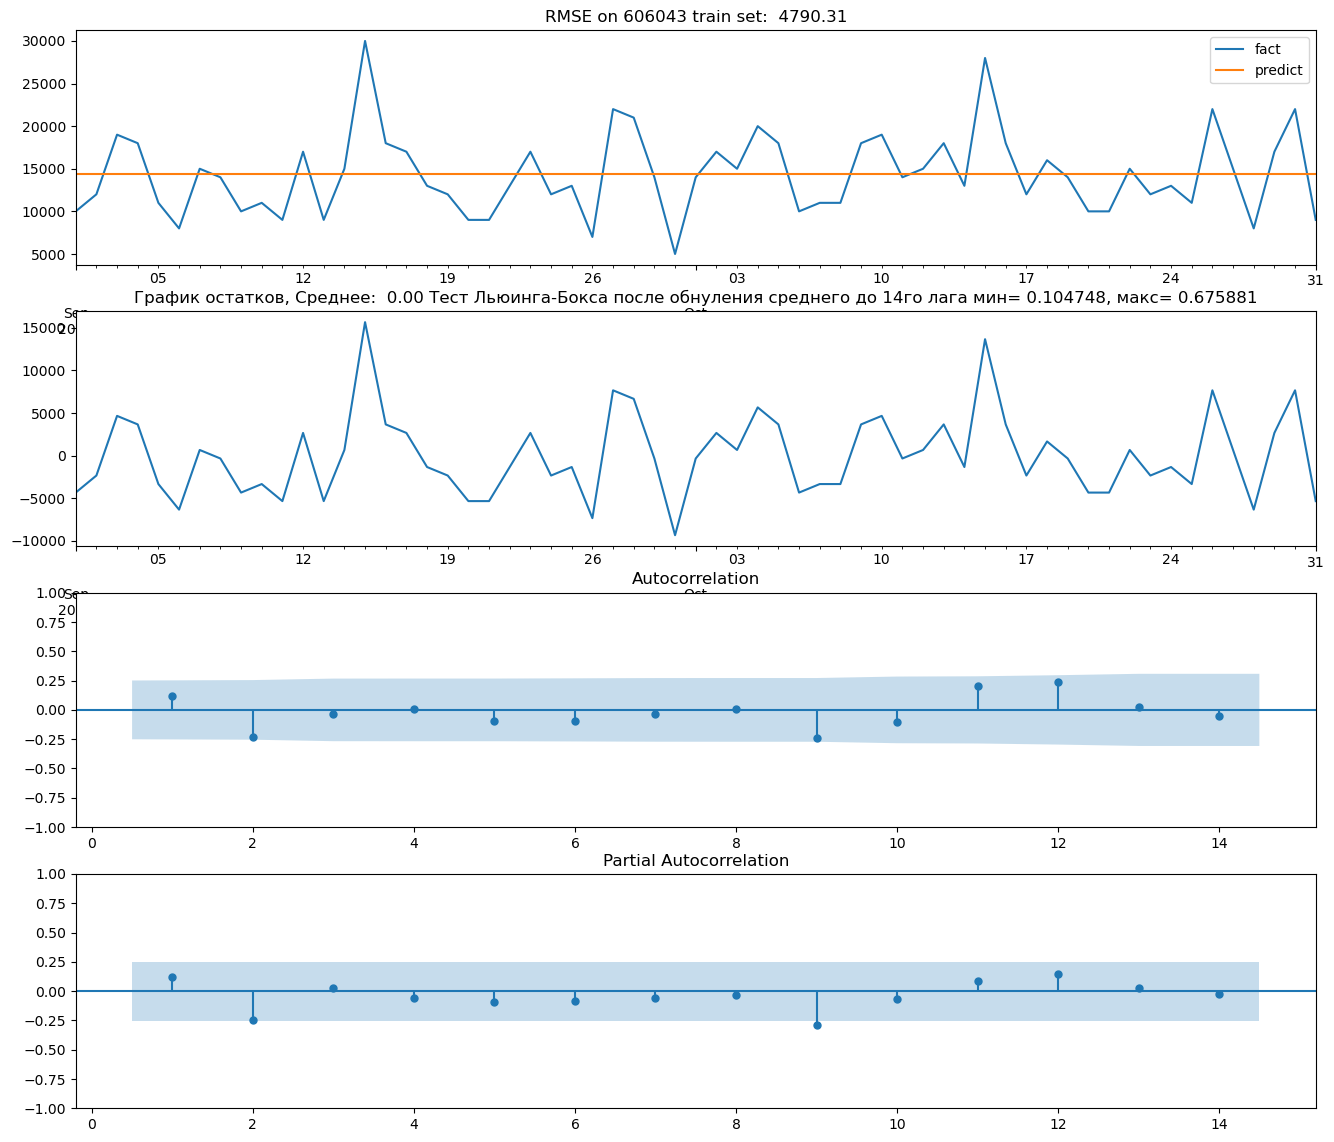

In [140]:
tid_modeling = tid_super_abnormal[0]
models_h[tid_modeling] = {}
models_h[tid_modeling]['arima_auto'] = show_predictions_autoarima(data[tid_modeling].copy(), season_order=7, show_train=True)

In [141]:
models_h[tid_modeling]['arima_auto'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   61
Model:                        SARIMAX   Log Likelihood                -603.491
Date:                Sun, 28 May 2023   AIC                           1210.981
Time:                        21:54:11   BIC                           1215.203
Sample:                    09-01-2022   HQIC                          1212.636
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.434e+04    699.087     20.519      0.000     1.3e+04    1.57e+04
sigma2      2.295e+07   3.82e+06      6.006      0.000    1.55e+07    3.04e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                10.12
Prob(Q):                              0.34   Prob(JB):                         0.01
Heteroskedasticity (H):               0.93   Skew:                             0.84
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Тренировка моделей.

In [142]:
#models_dict = {}
#models_results = pd.DataFrame()

file_name_4_results = 'models_rmse_train_valid'
AUTO_CV = 'arima_auto'
HANDY_CV = 'arima_h'

In [143]:
def models_dump(models):
    path = disk_name + project_name + path_2_results
    for name in models:
        with open(f'{path}/{name}.pkl', 'wb') as fl:
            pickle.dump(models[name], fl)
    return {}

def models_read(tids_lst_of_models=None):  
    models = {}
    path = disk_name + project_name + path_2_results
    files_lst = [fn for fn in os.listdir(path) if 'None.pkl' in fn]  
    if tids_lst_of_models is not None: 
        files_lst = [fn for fn in files_lst if int(fn.split('_')[0]) in tids_lst_of_models]
    for filename in files_lst: 
        with open(f'{path}/{filename}', 'rb') as pkl:
            models[int(filename.split('.')[0].split('_')[0])] = pickle.load(pkl)
    return models


def models_results_dump(results, fn=file_name_4_results, suff='_last'):
    #results.to_csv(fn)
    #print(fn)
    return csv_dump(df, fn=fn, suff=suff)

def models_read(tids_lst_of_models=None):  
    models = {}
    path = disk_name + project_name + path_2_results
    files_lst = [fn for fn in os.listdir(path) if 'None.pkl' in fn]  
    if tids_lst_of_models is not None: 
        files_lst = [fn for fn in files_lst if int(fn.split('_')[0]) in tids_lst_of_models]
    for filename in files_lst: 
        with open(f'{path}/{filename}', 'rb') as pkl:
            models[int(filename.split('.')[0].split('_')[0])] = pickle.load(pkl)
    return models

def test_a_model(model, tid, df=data, days_for_test=D_TEST): 
    ts_train = df[tid][:-days_for_test].copy()
    ts_test = df[tid][-days_for_test:].copy()
    prediction = model.predict(n_periods=days_for_test)
    predict_in_sample = model.predict_in_sample()
    rmse_test =  mean_squared_error(ts_test,  prediction) ** 0.5
    rmse_train = mean_squared_error(ts_train, predict_in_sample) ** 0.5
    return rmse_test, rmse_train

def add_result_2_df(index_for_results, tid, model_name, rmse_test, rmse_train, results_df=None):
    if results_df is None:
        results_df = pd.DataFrame()
    results_df.loc[index_for_results, 'tid'] = f'{tid}'
    results_df.loc[index_for_results, 'model_name'] = model_name
    results_df.loc[index_for_results, 'rmse_test'] = round(rmse_test)
    results_df.loc[index_for_results, 'rmse_train'] = round(rmse_train)
    return results_df

def models_test(models, df=data, days_for_test=D_TEST):
    results = pd.DataFrame()
    for tid in models:
        #tid = int(model_name.split('_')[0])
        ts_train = df[tid][:-days_for_test]#.copy()
        ts_test = df[tid][-days_for_test:]#.copy()
        curr_date = datetime.today().strftime('%Y-%m-%d')
        index_for_results = f'{tid} tid, {days_for_test} days for test. Testing on {curr_date}'
        rmse_test, rmse_train = test_a_model(models[tid], tid, df=df, days_for_test=days_for_test)
        add_result_2_df(results_df=results, index_for_results=index_for_results, tid=tid, model_name=f'{tid}_auto_arima', rmse_test=rmse_test, rmse_train=rmse_train)
    return results

In [144]:
def fit_auto_arima(tid, df=data, days_for_test=D_TEST, season_order=7, rank=None, **kwargs):
    ts_train = df[tid][:-days_for_test].copy()
    ts_test = df[tid][-days_for_test:].copy()
    model_fitted = pm.auto_arima(ts_train, seasonal=True, m=season_order, d=rank, **kwargs)
    model_name = f'{tid}_{AUTO_CV}_rank_{rank}'
    index_for_results = f'{tid} tid, {days_for_test} days for test'
    return model_fitted, model_name, index_for_results

def fit_auto_arima_list(tid_lst, df=data, days_for_test=D_TEST, season_order=7, rank=None, **kwargs):
    models = {}
    models_results = pd.DataFrame()
    for tid in tid_lst:
        model_fitted, model_name, index_for_results = fit_auto_arima(tid, df=df, days_for_test=days_for_test, season_order=season_order, rank=rank)
        models[model_name] = model_fitted
        rmse_test, rmse_train = test_a_model(model_fitted, tid, df=df, days_for_test=days_for_test)
        index_for_results = f'{index_for_results}. After CV fitting'
        add_result_2_df(results_df=models_results, index_for_results=index_for_results, tid=tid, model_name=model_name, rmse_test=rmse_test, rmse_train=rmse_train)
    return models, models_results

def fit_auto_arima_list_dump(tid_lst, batch_size=50, first_tid=0, df=data, days_for_test=D_TEST, season_order=7, rank=None, **kwargs):
    models_qnt = len(tid_lst) - first_tid
    steps = models_qnt // batch_size + 1
    for step in range(steps):
        print(f'Start {step}s step. Batch size = {batch_size}.')
        start_slice = first_tid + step * batch_size
        end_slice = start_slice + batch_size
        models_dict, models_results = fit_auto_arima_list(tid_lst[start_slice:end_slice], df=df, days_for_test=days_for_test, season_order=season_order, rank=rank)    
        models_dict = models_dump(models_dict)
        models_results = models_results_dump(models_results, suff=f'ttl{len(tid_lst)}_start{start_slice}_end{end_slice}')
        print(f'Save models from {start_slice} till {end_slice} from list')

In [145]:
# Здесь запускаем авто ариму для большого списка с сохранением результатов
# fit_auto_arima_list_dump(stationary[2], batch_size=10, rank=None)

# Создание класса для эксплуатации решения. 

Класс CashPredict реализует  модель прогноза временных рядов SARIMA для всех представленных в данных банковских терминалов. Для каждого терминала строится своя авторегрессионная модель. На этапе обучения модели (методы .fit_model, .fit_models) проводится кросс-валидационный поиск наилучший модели для данного ряда из пула моделей с различным сочетанием параметров сезонной авторегрессии (p=[1..5], d=[0..2], q[1..5])(P[1..5], D[0..1], Q[1..5], S=7) по критерию Акаике. На этапе исследования данных была проверена стационарность исходных данных - максимальной порядок дифференцирования до достижения стационарности составил d=2 (подробности в файле cash forecast.ipynb).

Обучение моделей производится только на train наборе данных (диапазон всех данных минус self.days_for_test=30 при инициировании объекта по умолчанию)


____________________________________________________________________________
ОСНОВНЫЕ методы :

.fit_model(tid) - если модель не обучена, запускает процесс обучения и выбора наилучшей модели на имеющемся train наборе данных для одного tid

.fit_models() - запускает процесс обучения и выбора наилучшей модели  для всех терминалов

.predict(id) - формирует прогноз для данного tid, если модели нет, сначала выполняет .fit

.predict_all() - возвращает результат .predict по всем терминалам

.predict_out(tid, days_out_of_data) - возвращает результат прогнозирования за пределами предоставленных данных (train + test), при этом модель не переобучается на всех данных, в комментариях есть реализация данного метода, который переобучает модель на всех данных, не производя при этом кросс-валидационного выбора (то есть параметры авторегрессии остаются теми, которые были определены как наилучшие на train данных), соответственно, такой метод будет отрабатывать достаточно быстро и лучше подходит для эксплуатации решения

.calc_error(tid) - вычисление ошибки прогнозирования - rmse, результаты теста Льюинга-Бокса на остатках

.show_prediction(tid) - выводит график исходного ряда и прогнозных значений (на train данных результат обучения, на test - результат прогноза)

.show_acf(tid) - выводит графики ACF/PACF для остатков раздельно для train (показывает качество полученной модели) и для test (показывает качество генерализации выбранного подхода)



### Тестирование кода для эксплуатации

In [146]:
class CashPredict:
    def __init__(self, name, 
                 data_df = None, 
                 models_dict = {}, 
                 days_for_test = 30,
                 path_2_project = '/',
                 path_4_data = 'data/',
                 path_4_results = 'results/',
                 csv_in = 'cash_in_terminals.csv',
                 col_cash_in = 'sum_start',
                 col_cash_in_excel = 'остаток на 31.08.2022 (входящий)',
                 col_tids = 'TID',
                 sep_in_csv = ';'
                 ): #tid_df,
        self.name = name
        self.days_for_test = days_for_test
        self.data = data_df
        
        self.models = models_dict
        self.has_predictions = {}
        self.fit_status = {}
        self.errors = {}
        
        self.plot_size = (16, 3)
        
        self.path_2_project = path_2_project
        self.path_4_data = path_4_data 
        self.path_4_results = path_4_results
        self.sep = sep_in_csv
        self.csv_in = csv_in
        self.col_cash_in = col_cash_in
        self.col_cash_in_excel = col_cash_in_excel
        self.col_tids = col_tids
        self.has_data = False
        self.has_prepared = False
        self.prepare_data()

    def read_csv_in(self):
        self.data = pd.read_csv(self.path_2_project + 
                                self.path_4_data + 
                                self.csv_in, 
                                sep = self.sep)
        self.has_data = True
    
    def prepare_data(self):
        if self.has_prepared:
            return
        if not self.has_data:
            self.read_csv_in()
        self.data.rename(columns={self.col_cash_in_excel : self.col_cash_in}, inplace=True)
        self.data.drop(columns=[self.col_cash_in], inplace=True)

        self.data = self.data.transpose()
        self.data.columns = self.data.loc[self.col_tids].values
        self.data.drop(index=self.col_tids, axis=0, inplace=True)
        self.data.index = pd.to_datetime(self.data.index)
        
        self.tids = self.data.columns
        #self.tid_df = tid_df.copy()
        self.predictions = pd.DataFrame(index=self.data.index, columns=self.tids)
        # self.predictions_daily = pd.DataFrame(index=self.data.index)
        self.errors = {tid: {} for tid in self.tids} # словари для tid : {'resid':ts, 'rmse': {'train':, 'test': }, 'lbox':{'train':, 'test':}}
        self.fit_status = {tid: True if tid in self.models else False for tid in self.tids}
        self.tid_f = 0
        self.has_prepared = True

    def fit_model(self, tid, season_order=7, rank=None, **kwargs): # если season_order=1, автоарима отключит CV с сезонной компонентой
        if not self.fit_status[tid]:
            ts_train, _ = self.split(self.data[tid])
            self.models[tid] =  pm.auto_arima(ts_train, seasonal=True, m=season_order, d=rank, **kwargs) # если rank=None, автоарима сама подберет нужный порядок
            self.fit_status[tid] = True
    
    def fit_models(self):
        for tid in self.data.columns.tolist()[self.tid_f:]:
            self.tid_f += 1 # здесь инкрементируется заранее, чтобы не пытаться заново  фитить данные с какой-то ошибкой
            self.fit_model(tid)

    def predict_date(self, tid, date):
        if not self.has_predictions.get(tid, False):
            self.predict(tid)
        return self.data.loc[date, tid], round(self.predictions.loc[date, tid]) # (реальный прирост, прогноз)

    def predict(self, tid):
        if not self.fit_status[tid]:
            self.fit_model(tid)
        model_fitted = self.models[tid]
        prediction_train = model_fitted.predict_in_sample()
        prediction_test = model_fitted.predict(n_periods=self.days_for_test)
        self.predictions[tid] = pd.concat([prediction_train, prediction_test])
        self.has_predictions[tid] = True
        self.calc_error(tid)
        
    def predict_all(self):
        for tid in self.tids:
            if not self.has_predictions.get(tid, False):
                self.predict(tid)
        return self.predictions

    def predict_out(self, tid, days_out_of_data):
        if not self.fit_status[tid]:
            self.fit_model(tid)
        # model_fitted = self.models[tid]
        prediction_out = self.models[tid].predict(n_periods=self.days_for_test + days_out_of_data)
        return prediction_out[-days_out_of_data:]

    def split(self, ts):
        return ts[:-self.days_for_test], ts[-self.days_for_test:] # train, test
       
    def calc_error(self, tid, max_lags=14):
        if not self.has_predictions.get(tid, False):
            self.predict(tid)
        y_hat, y_true = self.predictions[tid], self.data[tid]
        y_hat_train, y_hat_test  = self.split(y_hat)
        y_train, y_test = self.split(y_true)
        resid = y_hat - y_true
        self.errors[tid]['resid'] = resid
        self.errors[tid]['rmse'] = {}
        self.errors[tid]['rmse']['train'] = round(mean_squared_error(y_train, y_hat_train) ** 0.5)
        self.errors[tid]['rmse']['test'] = round(mean_squared_error(y_test, y_hat_test) ** 0.5)
        # ts_to_lbox = self.errors[tid]['resid']#[]
        resid_train, resid_test = self.split(resid)
        lbox_train = sm.stats.diagnostic.acorr_ljungbox(resid_train - np.mean(resid_train), lags=max_lags, return_df=True)
        lbox_test = sm.stats.diagnostic.acorr_ljungbox(resid_test - np.mean(resid_test), lags=max_lags, return_df=True)
        self.errors[tid]['lbox'] = {}
        self.errors[tid]['lbox']['train'] = lbox_train
        self.errors[tid]['lbox']['test'] = lbox_test

    def add_comments(self, comments_dict):
        self.comments = comments_dict
        
    def show_prediction(self, tid):  # , show_acf=True, max_lags=7
        if not self.has_predictions.get(tid, False):
            self.predict(tid)
        ax = self.predictions[tid].plot(figsize=(self.plot_size[0], self.plot_size[1]), grid=True)
        self.data[tid].plot(ax=ax, grid=True)
        ax.set_title(f'Реальность и прогноз для терминала {tid}. RMSE на train: { self.errors[tid]["rmse"]["train"] }, RMSE на test: {self.errors[tid]["rmse"]["test"]}', fontsize=10) 
        ax.tick_params(axis='x', labelsize=0)
        ax.axvline(self.data.index[-self.days_for_test], color='red', linestyle=':')

    def show_acf(self, tid, max_lags=14):
        if not self.has_predictions.get(tid, False):
            self.predict(tid)
        fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(self.plot_size[0], 4 * (self.plot_size[1] + .5)))
        t_acf = 'Автокорреляция остатков на '
        t_pacf = 'Частная автокорреляция остатков на '
        plot_acf(self.split(self.errors[tid]['resid'])[0], lags=list(range(1, max_lags+1)), ax=axs[0])
        axs[0].set_title(t_acf + 'train', fontsize=10)
        plot_pacf(self.split(self.errors[tid]['resid'])[0], lags=list(range(1, max_lags+1)), method='ywm', ax=axs[1]) # 'ywm' make PACF in [-1,1]
        axs[1].set_title(t_pacf + 'train', fontsize=10)
        plot_acf(self.split(self.errors[tid]['resid'])[1], lags=list(range(1, max_lags+1)), ax=axs[2])
        axs[2].set_title(t_acf + 'test', fontsize=10)
        plot_pacf(self.split(self.errors[tid]['resid'])[1], lags=list(range(1, max_lags+1)), method='ywm', ax=axs[3]) # 'ywm' make PACF in [-1,1]
        axs[3].set_title(t_pacf + 'test', fontsize=10)

""" Этот вариант метода делает переобучение, что вообще говоря для прода правильно и лучше использовать именно такой подход,
однако в условиях тестирования нашей концепции, это не очень хорошо:
  - делая прогноз на каждый следующий день с использованием не только train данных, но всех доступных данных к предыдущей для прогноза дате
    мы не сможем воспроизвести прогнозные данные на вчера/позавчера и т.д., поскольку вчерашней, позавчерашней модели уже нет
  - можно конечно сохранять модели за предыдущие дни, но тогда наш объект должен хранить как минимум 1630*30 моделей

    def predict_out(self, tid, days_out_of_data):
        if not self.fit_status[tid]:
            self.fit_model(tid)
        model_fitted = self.models[tid]
        prediction_out = self.models[tid].fit_predict(self.data[tid], n_periods=days_out_of_data)
        self.predictions[tid] = self.models[tid].predict_in_sample()
        return prediction_out
"""

' Этот вариант метода делает переобучение, что вообще говоря для прода правильно и лучше использовать именно такой подход,\nоднако в условиях тестирования нашей концепции, это не очень хорошо:\n  - делая прогноз на каждый следующий день с использованием не только train данных, но всех доступных данных к предыдущей для прогноза дате\n    мы не сможем воспроизвести прогнозные данные на вчера/позавчера и т.д., поскольку вчерашней, позавчерашней модели уже нет\n  - можно конечно сохранять модели за предыдущие дни, но тогда наш объект должен хранить как минимум 1630*30 моделей\n\n    def predict_out(self, tid, days_out_of_data):\n        if not self.fit_status[tid]:\n            self.fit_model(tid)\n        model_fitted = self.models[tid]\n        prediction_out = self.models[tid].fit_predict(self.data[tid], n_periods=days_out_of_data)\n        self.predictions[tid] = self.models[tid].predict_in_sample()\n        return prediction_out\n'

In [148]:
# создается новый объект CashPredict, содержащий только входные CSV данные

path_project = './' #mount_name + '/MyDrive/Colab Notebooks/ds_hack2023/'
path_data = 'data/' # поддиректория, с CSV файлом данных и pickle обученной модели


cp_empty = CashPredict('all_auto_arima',
                           # models_dict = all_fitted,
                            path_2_project = path_project, 
                            path_4_data = path_data) 
#pt_fail.fit_models()

In [150]:
# read all models and all data
import pickle
import os
path_project = './' # mount_name + '/MyDrive/Colab Notebooks/ds_hack2023/'
path_data = 'data/' # поддиректория, с CSV файлом данных и pickle обученной модели

path_pickle = path_project + path_data

fname = [fn for fn in os.listdir(path_pickle) if '.pkl' in fn][0]

with open(path_pickle + fname, 'rb') as pkl:
    cp_fitted = pickle.load(pkl)


In [151]:
#pt_1
#pt_fitted.tids
#cp_fitted.tids
cp_empty.tids

Int64Index([406136, 406139, 406145, 406148, 406180, 406190, 406196, 406504,
            406509, 406536,
            ...
            699451, 699540, 699560, 699572, 699577, 699578, 699579, 699629,
            699641, 699664],
           dtype='int64', length=1630)

In [152]:
ft = cp_fitted.fit_status # pt_1
sum([ft[ind] for ind in ft])

1630

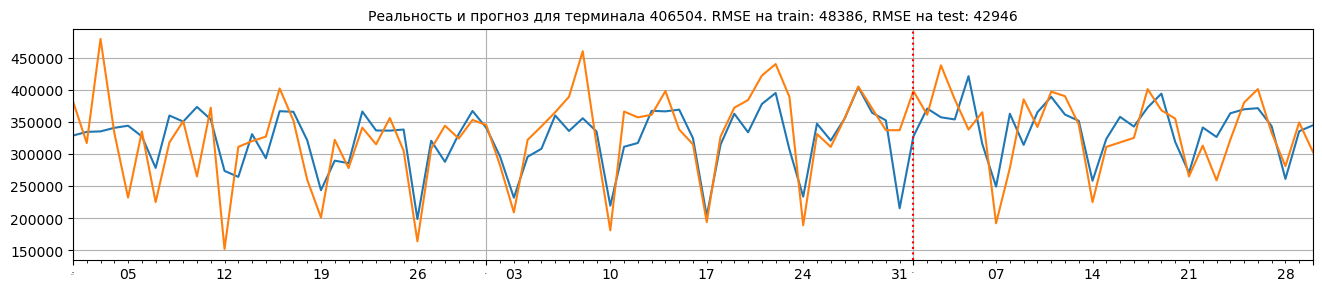

In [153]:
cp_empty.show_prediction(406504)